In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('volk_polo_used_dataset.csv', index_col=0)

In [4]:
df.head()

,city,model,photos,vin,владельцы,год выпуска,двигатель,коробка,кузов,налог,...,госномер,онлайн-показ,1 владелец,дтп ненайдены,почти как новый,гарантия,на гарантии,продаёт собственник,медленно теряет вцене,кузов №
0,архангельск,volkswagen polo v,1.000,xw8**************,2владельца,2012,1.6 л / 105л.с. / бензин,механическая,седан,2625₽ / год,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,санкт-петербург,volkswagen polo v рестайлинг,1.000,xw8**************,2владельца,2017,1.6 л / 90л.с. / бензин,механическая,седан,2160₽ / год,...,******|198,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,минеральные воды,volkswagen polo v,1.000,xw8**************,1владелец,2014,1.6 л / 105л.с. / бензин,механическая,седан,1575₽ / год,...,NaN,NaN,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN
3,северская,volkswagen polo v рестайлинг,1.000,xw8**************,1владелец,2018,1.6 л / 110л.с. / бензин,механическая,седан,2750₽ / год,...,******|123,NaN,1.000,NaN,1.000,NaN,NaN,NaN,NaN,NaN
4,бирск,volkswagen polo v рестайлинг,1.000,xw8**************,2владельца,2019,1.6 л / 110л.с. / бензин,автоматическая,седан,3850₽ / год,...,******|702,NaN,NaN,1.000,NaN,до марта 2030,1.000,NaN,NaN,NaN


In [5]:
len(df)

2914

In [6]:
df['city'].value_counts().head(10)

москва             387
санкт-петербург    231
екатеринбург       122
краснодар           94
воронеж             67
ростов-на-дону      66
нижний новгород     55
уфа                 54
челябинск           53
самара              50
Name: city, dtype: int64

In [7]:
df['city'].value_counts().head(10).sum()

1179

In [8]:
df.columns

Index(['city', 'model', 'photos', 'vin', 'владельцы', 'год выпуска',
       'двигатель', 'коробка', 'кузов', 'налог', 'обмен', 'описание', 'привод',
       'пробег', 'птс', 'руль', 'состояние', 'таможня', 'цвет', 'цена',
       'владение', 'госномер', 'онлайн-показ', '1 владелец', 'дтп ненайдены',
       'почти как новый', 'гарантия', 'на гарантии', 'продаёт собственник',
       'медленно теряет вцене', 'кузов №'],
      dtype='object')

In [9]:
df = df.rename(columns={'владельцы': 'owners', 'год выпуска': 'year_of_release',
                        'двигатель': 'engine', 'коробка': 'transmission',
                        'кузов': 'car_type', 'налог': 'tax', 'привод': 'drive_type',
                        'описание': 'description', 'пробег': 'mileage', 'птс': 'ptc',
                        'руль': 'steering_wheel', 'состояние': 'condition', 
                        'таможня': 'customhouse', 'цвет': 'color', 'цена': 'price',
                        'обмен': 'exchange', 'гарантия': 'guarantee', 'владение': 'ownership',
                        'кузов №': 'body_type_number', 'запас хода': 'capacity reserve',
                        'госномер': 'gos_num', 'кузов №': 'body_nomber', 'почти как новый': 'just_like_new',
                        'дтп ненайдены': 'no_dtp', 'онлайн-показ': 'online_show',
                        '1 владелец': 'one_owner', 'комплектация': 'equipment',
                        'продаёт собственник': 'sells_owner', 'на гарантии': 'on_guarantee',
                        'проверенный автомобиль': 'checked_auto', 'медленно теряет вцене': 'loses_price'})

In [10]:
df.columns

Index(['city', 'model', 'photos', 'vin', 'owners', 'year_of_release', 'engine',
       'transmission', 'car_type', 'tax', 'exchange', 'description',
       'drive_type', 'mileage', 'ptc', 'steering_wheel', 'condition',
       'customhouse', 'color', 'price', 'ownership', 'gos_num', 'online_show',
       'one_owner', 'no_dtp', 'just_like_new', 'guarantee', 'on_guarantee',
       'sells_owner', 'loses_price', 'body_nomber'],
      dtype='object')

### Take nlp part

In [11]:
nlp_part = df['description']
df = df.drop(columns=['description'])

### Mileage

In [12]:
df['mileage'] = df['mileage'].apply(lambda x: str(x).replace('км', '')).astype('int')

### Engine

In [13]:
def split_engine_be_features(engine_str):
    engine_split = engine_str.split('/')
    
    engine_volume = engine_split[0].strip().split(' ')[0]
    engine_power = engine_split[1].strip().split(' ')[0]
    engine_type = engine_split[2].strip()
    
    return engine_volume, engine_power, engine_type

In [14]:
df['engine_volume'], df['engine_power'], df['engine_type'] = zip(*df['engine'].map(split_engine_be_features))

df['engine_volume'] = df['engine_volume'].astype('float')

df['engine_power'] = df['engine_power'].apply(lambda x: str(x).replace('л.с.', '')).astype('int')
df['engine_power'] = df['engine_power'].astype('int')

### Tax

In [15]:
df = df[~df['tax'].isna()]

In [16]:
df.loc[~df['tax'].isna(), 'tax'] = df['tax'].apply(lambda x: str(x).replace('₽ / год', '')).astype('int')

### Online_show

In [17]:
df.loc[~df['online_show'].isna(), 'online_show'] = True
df.loc[df['online_show'].isna(), 'online_show'] = False

### Car_type

In [18]:
df['car_type'].value_counts()

седан              2614
хэтчбек 5 дв.       194
лифтбек              51
хэтчбек 3 дв.        45
универсал 5 дв.       6
Name: car_type, dtype: int64

In [19]:
df = df.loc[df['car_type'] == 'седан']

### Color

### 

In [20]:
df['color'].value_counts()

белый          1121
серебристый     388
чёрный          353
серый           227
синий           205
коричневый      121
бежевый          85
красный          62
жёлтый           28
зелёный          10
пурпурный         5
золотистый        5
оранжевый         2
голубой           1
фиолетовый        1
Name: color, dtype: int64

In [21]:
df['color'].value_counts(normalize=True) < 0.01

белый          False
серебристый    False
чёрный         False
серый          False
синий          False
коричневый     False
бежевый        False
красный        False
жёлтый         False
зелёный         True
пурпурный       True
золотистый      True
оранжевый       True
голубой         True
фиолетовый      True
Name: color, dtype: bool

### Owners

In [22]:
df['owners'].value_counts()

1владелец      1280
2владельца      727
3 или более     607
Name: owners, dtype: int64

In [23]:
df.loc[(df['one_owner'] == 1.0) | (df['owners'] == '1владелец'), 'owners'] = '1'
df.loc[df['owners'] == '2владельца', 'owners'] = '2'
df.loc[df['owners'] == '3 или более', 'owners'] = '3+'

### Year_of_release

In [24]:
df['year_of_release'].value_counts().head(10)

2016    430
2018    344
2017    338
2013    278
2019    241
2015    232
2012    226
2014    199
2011    198
2020     49
Name: year_of_release, dtype: int64

In [25]:
df['year_of_release'] = df['year_of_release'].astype('int')

In [26]:
df = df.loc[df['year_of_release'].isin(df['year_of_release'].value_counts().head(10).index)]

### No_dtp

In [27]:
df['no_dtp'].value_counts(dropna=False)

NaN      1406
1.000    1129
Name: no_dtp, dtype: int64

In [28]:
df.loc[~df['no_dtp'].isna(), 'no_dtp'] = 'true'
df.loc[df['no_dtp'].isna(), 'no_dtp'] = 'unknown'

In [29]:
df['no_dtp'].value_counts()

unknown    1406
true       1129
Name: no_dtp, dtype: int64

### Exchange

In [30]:
df['exchange'].value_counts(dropna=False)

NaN                   1740
рассмотрю варианты     795
Name: exchange, dtype: int64

In [31]:
df['exchange'] = df['exchange'].apply(lambda x: True if pd.notna(x) else False)

In [32]:
df['exchange'].value_counts(dropna=False)

False    1740
True      795
Name: exchange, dtype: int64

### Ptc

In [33]:
df['ptc'].value_counts(dropna=False)

оригинал    2419
дубликат     116
Name: ptc, dtype: int64

### Sells_owner

In [34]:
df['sells_owner'].value_counts(dropna=False)

NaN      2284
1.000     251
Name: sells_owner, dtype: int64

In [35]:
df.loc[df['sells_owner'] == 1.0, 'sells_owner'] = 'true'
df.loc[df['sells_owner'].isna(), 'sells_owner'] = 'unknown'

In [36]:
df['sells_owner'].value_counts(dropna=False)

unknown    2284
true        251
Name: sells_owner, dtype: int64

### Price

In [37]:
df['price'] = df['price'].apply(lambda x: x.split(' ')[-1].replace('₽', '').strip()).astype('int')

### Model

In [38]:
df['model'].value_counts()

volkswagen polo v рестайлинг    1544
volkswagen polo v                991
Name: model, dtype: int64

In [39]:
df = df.loc[df['model'].isin(df['model'].value_counts().loc[df['model'].value_counts(normalize=True) > 0.05].index)]

### Photos

In [40]:
df['photos'].value_counts()

1.000    2268
0.000     267
Name: photos, dtype: int64

In [41]:
df.loc[df['photos'] == 1.0, 'photos'] = True
df.loc[df['photos'] == 0.0, 'photos'] = False

In [42]:
df['photos'].value_counts()

True     2268
False     267
Name: photos, dtype: int64

## Пробуем без города

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2535 entries, 0 to 2913
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             2535 non-null   object 
 1   model            2535 non-null   object 
 2   photos           2535 non-null   object 
 3   vin              2524 non-null   object 
 4   owners           2535 non-null   object 
 5   year_of_release  2535 non-null   int64  
 6   engine           2535 non-null   object 
 7   transmission     2535 non-null   object 
 8   car_type         2535 non-null   object 
 9   tax              2535 non-null   int64  
 10  exchange         2535 non-null   bool   
 11  drive_type       2535 non-null   object 
 12  mileage          2535 non-null   int64  
 13  ptc              2535 non-null   object 
 14  steering_wheel   2535 non-null   object 
 15  condition        2535 non-null   object 
 16  customhouse      2535 non-null   object 
 17  color         

In [44]:
df.columns

Index(['city', 'model', 'photos', 'vin', 'owners', 'year_of_release', 'engine',
       'transmission', 'car_type', 'tax', 'exchange', 'drive_type', 'mileage',
       'ptc', 'steering_wheel', 'condition', 'customhouse', 'color', 'price',
       'ownership', 'gos_num', 'online_show', 'one_owner', 'no_dtp',
       'just_like_new', 'guarantee', 'on_guarantee', 'sells_owner',
       'loses_price', 'body_nomber', 'engine_volume', 'engine_power',
       'engine_type'],
      dtype='object')

In [45]:
columns_to_remove = ['city', 'engine', 'drive_type', 'one_owner',
                     'vin', 'steering_wheel', 'condition',
                     'gos_num', 'ownership', 'guarantee', 
                     'on_guarantee', 'loses_price', 'engine_type',
                     'just_like_new', 'body_nomber', 'car_type',
                     'customhouse']

In [46]:
df = df.drop(columns=columns_to_remove)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2535 entries, 0 to 2913
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            2535 non-null   object 
 1   photos           2535 non-null   object 
 2   owners           2535 non-null   object 
 3   year_of_release  2535 non-null   int64  
 4   transmission     2535 non-null   object 
 5   tax              2535 non-null   int64  
 6   exchange         2535 non-null   bool   
 7   mileage          2535 non-null   int64  
 8   ptc              2535 non-null   object 
 9   color            2535 non-null   object 
 10  price            2535 non-null   int64  
 11  online_show      2535 non-null   object 
 12  no_dtp           2535 non-null   object 
 13  sells_owner      2535 non-null   object 
 14  engine_volume    2535 non-null   float64
 15  engine_power     2535 non-null   int64  
dtypes: bool(1), float64(1), int64(5), object(9)
memory usage: 31

In [48]:
cols_with_incorrect_low_values = ['color', 'engine_volume', 'engine_power']
for col in cols_with_incorrect_low_values:
    values_above = df[col].value_counts().loc[df[col].value_counts(normalize=True) < 0.05].index
    df = df[~df[col].isin(values_above)]

In [49]:
df.nunique()

model                 2
photos                2
owners                3
year_of_release      10
transmission          2
tax                  70
exchange              2
mileage            1107
ptc                   2
color                 5
price               428
online_show           2
no_dtp                2
sells_owner           2
engine_volume         1
engine_power          3
dtype: int64

In [50]:
len(df)

2117

### Concert categorical and numeric features

In [51]:
categorical_features = ['model', 'photos', 'transmission', 'online_show', 'color', 'owners',
                        'no_dtp', 'exchange', 'ptc', 'sells_owner', 
                        'engine_volume', 'engine_power']

numeric_features = ['tax', 'year_of_release', 'mileage']

In [52]:
df = pd.get_dummies(data=df, columns=categorical_features, drop_first=True)

In [53]:
for num_feature in numeric_features:
    df[num_feature] = df[num_feature].astype('int')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2913
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   year_of_release                     2117 non-null   int64
 1   tax                                 2117 non-null   int64
 2   mileage                             2117 non-null   int64
 3   price                               2117 non-null   int64
 4   model_volkswagen polo v рестайлинг  2117 non-null   uint8
 5   photos_True                         2117 non-null   uint8
 6   transmission_механическая           2117 non-null   uint8
 7   online_show_True                    2117 non-null   uint8
 8   color_серебристый                   2117 non-null   uint8
 9   color_серый                         2117 non-null   uint8
 10  color_синий                         2117 non-null   uint8
 11  color_чёрный                        2117 non-null   uint8
 12  owners

### Drop NA

In [55]:
df = df.dropna(how='any')

### Split data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']),
                                                    df['price'], 
                                                    test_size=0.25)

In [57]:
X_train.shape, X_test.shape

((1587, 19), (530, 19))

### Scaling

In [58]:
scaler_x = MinMaxScaler()
X_train[numeric_features] = scaler_x.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler_x.transform(X_test[numeric_features])

## Modeling

In [65]:
y_train.median(), y_test.median()

(630000.0, 632000.0)

### BaseLine

In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [67]:
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [68]:
median_train = y_train.median()
baseline = np.array([median_train] * len(y_test))
measured_metrics['baseline'] = dataframe_metrics(y_test, baseline)
measured_metrics

,error_type,baseline
0,MAE,139256.651
1,RMSE,166048.776
2,R2,-0.000
3,MAPE,24.432


### Linear Reg

In [69]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

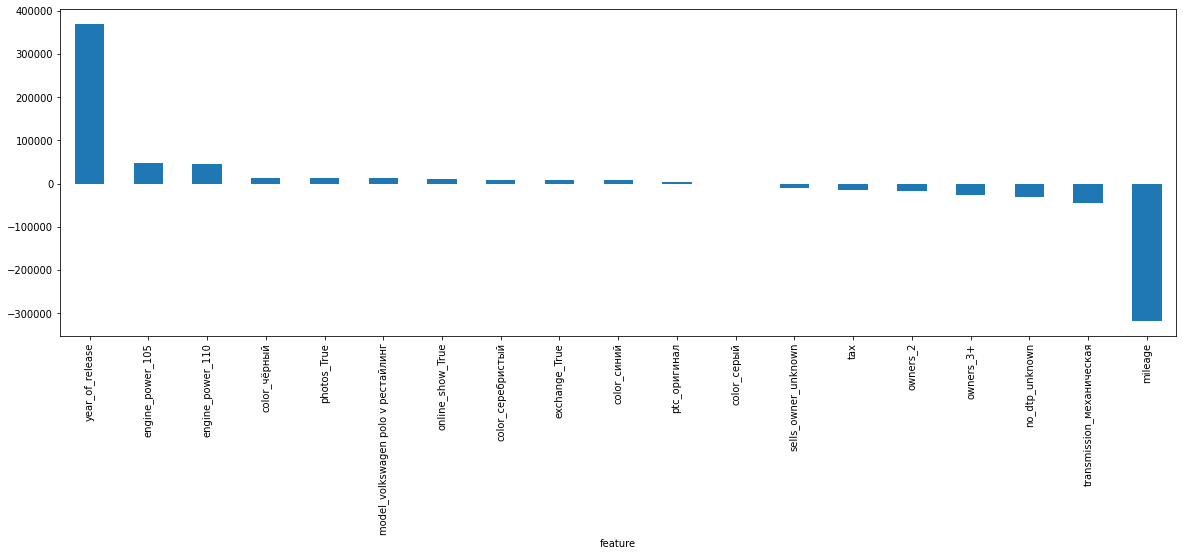

In [70]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(20, 6));

In [71]:
predictions = lin_reg.predict(X_test)

In [72]:
measured_metrics["lin_reg"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg
0,MAE,139256.651,45860.919
1,RMSE,166048.776,58662.071
2,R2,-0.000,0.875
3,MAPE,24.432,7.817


In [73]:
df[['price']].describe()

,price
count,2117.000
mean,626690.607
std,163149.816
min,265000.000
25%,485000.000
50%,630000.000
75%,749000.000
max,1080000.000


## RidgeCV

In [74]:
ridge_cv = RidgeCV()

ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

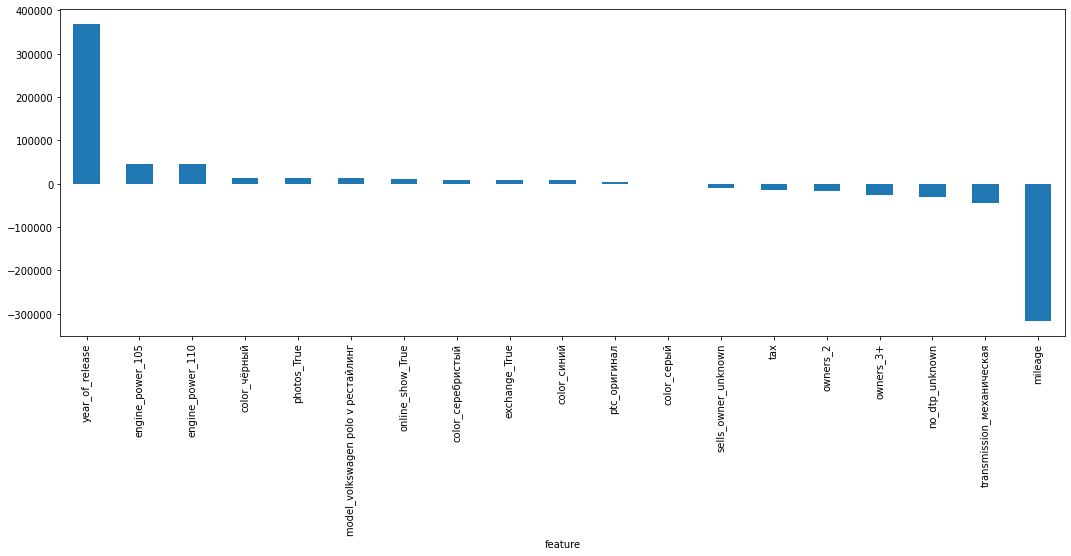

In [75]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

In [76]:
predictions = ridge_cv.predict(X_test)
measured_metrics["ridge_cv"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg,ridge_cv
0,MAE,139256.651,45860.919,45856.430
1,RMSE,166048.776,58662.071,58655.531
2,R2,-0.000,0.875,0.875
3,MAPE,24.432,7.817,7.814


## LassoCV

In [77]:
lasso_cv = LassoCV()

lasso_cv.fit(X_train, y_train)

LassoCV()

,error_type,baseline,lin_reg,ridge_cv,lasso_cv
0,MAE,139256.651,45860.919,45856.430,45817.927
1,RMSE,166048.776,58662.071,58655.531,58653.716
2,R2,-0.000,0.875,0.875,0.875
3,MAPE,24.432,7.817,7.814,7.799


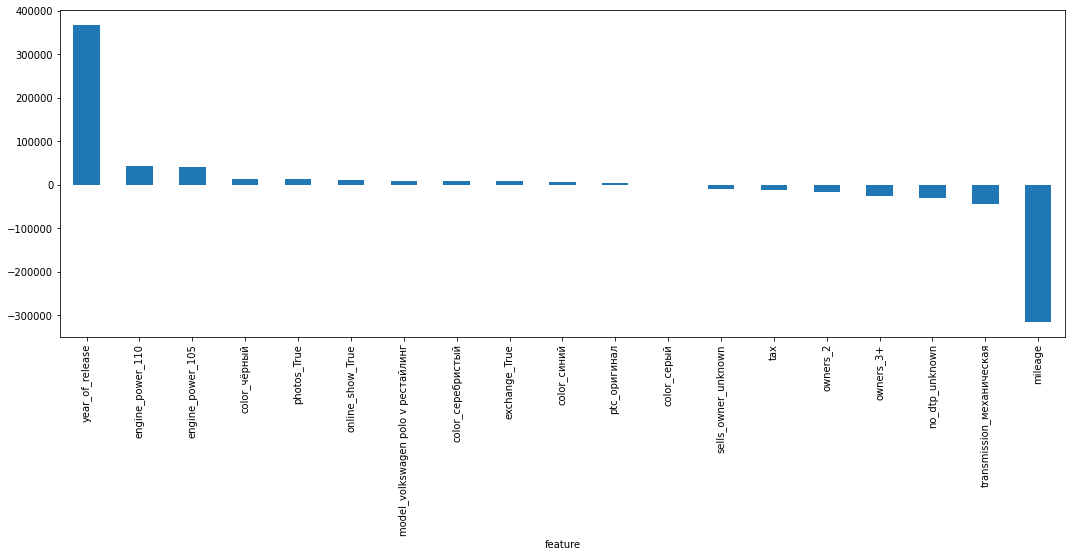

In [78]:
featureImportance = pd.DataFrame({"feature": X_train.columns[lasso_cv.coef_!=0], 
                                  "importance": lasso_cv.coef_[lasso_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

### Random Forest

In [79]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

measured_metrics["rf_reg"] = dataframe_metrics(y_test, rf_reg.predict(X_test))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg
0,MAE,139256.651,45860.919,45856.430,45817.927,47102.953
1,RMSE,166048.776,58662.071,58655.531,58653.716,60810.136
2,R2,-0.000,0.875,0.875,0.875,0.866
3,MAPE,24.432,7.817,7.814,7.799,7.921


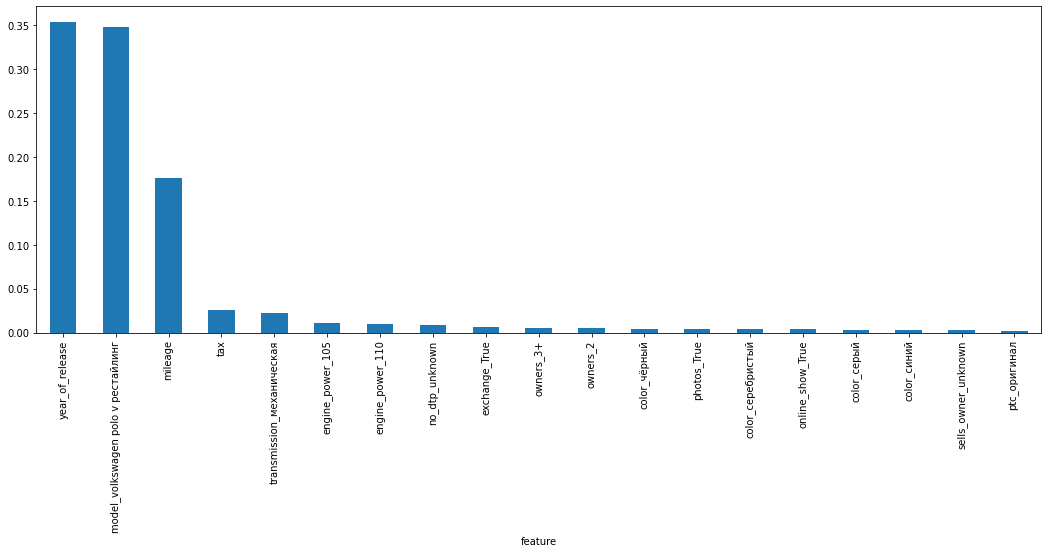

In [80]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": rf_reg.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));